# Probabilitic Classification

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pth
import torch
import torch.distributions as torchdist
import torchvision
import torch.nn.functional as F
from tqdm import tqdm

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
class NormalDistLayer(torch.nn.Module):
    def __init__(self, n_latent_dim, n_classes):
        super(NormalDistLayer, self).__init__()
        self.n_latent_dim = n_latent_dim
        self.n_classes = n_classes
        
        # mu and sigma represent mean and var of Normal distribution of  N classes.
        self.mu = torch.nn.Parameter(torch.FloatTensor(n_classes, n_latent_dim))
        self.log_sigma = torch.nn.Parameter(torch.FloatTensor(n_classes, n_latent_dim))
        # self.mu = torch.nn.Parameter(torch.tensor([[0., 0.], [2., 0.]]))
        # self.log_sigma = torch.nn.Parameter(torch.tensor([[0., 0.], [-0.5, -0.5]]))
        torch.nn.init.xavier_uniform_(self.mu)
        torch.nn.init.xavier_uniform_(self.log_sigma)
        
        self.epsilon = 1e-7
        
    def forward(self, z_mu, z_log_sigma):
        """
        Parameters
        ----------
        z_mu: torch.Tensor, shape of (batch, n_latent_dim)
        z_log_sigma: torch.Tensor, shape of (batch, n_latent_dim)
        """
        z_sigma = torch.exp(z_log_sigma)
        sigma = torch.exp(self.log_sigma)
        
        sims = []
        batch_size = z_mu.size(0)
        for i in range(batch_size):
            # shape of (n_classes, n_latent_dim)
            # print('mu: %s' % str(self.mu.detach().numpy()))
            # print('z_mu[i]: %s' % str(z_mu[i].detach().numpy()))
            diff_mu = self.mu - z_mu[i]
            sum_sigma = sigma**2 + z_sigma[i]**2
            # print('diff_mu: %s sum_sigma: %s' % 
            #      (str(diff_mu.detach().numpy()), str(sum_sigma.detach().numpy())))
            # return
            # shape of (n_classes,)
            sim = -1/2 * (diff_mu**2 / (sum_sigma + self.epsilon) 
                           + torch.log(sum_sigma + self.epsilon)).sum(dim=1)
            # sim = (diff_mu**2).sum(dim=1)
            #print('sim: %s' % sim.detach().numpy())
            sims.append(sim)
            
            
        
        # shape of (batch, n_classes)
        sims = torch.stack(sims, dim=0)
        
        return sims

class NormalLinear(torch.nn.Module):
    def __init__(self):
        super(NormalLinear, self).__init__()
        self.fc = torch.nn.Linear(4, 10)
        
    def forward(self, z_mu, z_log_sigma):
        x = torch.cat([z_mu, z_log_sigma], dim=1)
        x = self.fc(x)
        
        return x

In [0]:
model = NormalDistLayer(2, 2)

In [0]:
x_mu = torch.tensor([1., 0.]).view(1, 2)
x_log_sigma = torch.tensor([0., 0.]).view(1, 2)

In [6]:
model(x_mu, x_log_sigma)

tensor([[-0.5904, -1.8589]], grad_fn=<StackBackward>)

In [0]:
class ConvNet(torch.nn.Module):
    def __init__(self, n_latent_dim):
        super(ConvNet, self).__init__()
        self.n_latent_dim = n_latent_dim
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(8, 16, 3),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.fc = torch.nn.Linear(32, 2*n_latent_dim)        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # GAP
        x = F.relu(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        z_mu = x[:, :self.n_latent_dim]
        z_log_sigma = x[:, self.n_latent_dim:]
        # print('z_mu size: %s z_log_sigma size: %s' % (z_mu.size(), z_log_sigma.size()))
        # print('z_mu: %s z_log_sigma: %s' % (z_mu.detach().numpy(), z_log_sigma.detach().numpy()))
        
        return z_mu, z_log_sigma
    
class ConvNet2(torch.nn.Module):
    def __init__(self, n_latent_dim):
        super(ConvNet2, self).__init__()
        self.n_latent_dim = n_latent_dim
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(8, 16, 3),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.fc = torch.nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # GAP
        x = F.relu(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x

## mnist

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [0]:
trn_trnsfms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485],
        std=[0.220]
    )
])

train_dataset = torchvision.datasets.MNIST('../data', transform=trn_trnsfms, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           drop_last=True
                                          )

In [0]:
N_DIM = 2
N_CLASSES = 10

model = ConvNet(N_DIM).to(device)
norm_dist_layer = NormalDistLayer(N_DIM, N_CLASSES).to(device)
# norm_dist_layer = NormalLinear()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([{'params': model.parameters()}, {
                 'params': norm_dist_layer.parameters()}], lr=1e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [0]:
def train():
    for epoch in range(10):
        loss_meter = AverageMeter()
        top1 = AverageMeter()
        top5 = AverageMeter()
        
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            img, label = data
            img, label = img.to(device), label.to(device)
            with torch.set_grad_enabled(True):
                z_mu, z_log_sigma = model(img)
                logit = norm_dist_layer(z_mu, z_log_sigma)
                # print(logit.size())
                # logit = model(img)
                loss = criterion(logit, label)

                prec1, prec5 = accuracy(logit.detach(), label, topk=(1, 5))
                loss_meter.update(loss.item(), img.size(0))
                top1.update(prec1.item(), img.size(0))
                top5.update(prec5.item(), img.size(0))

                # backward
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            # print('mu', norm_dist_layer.mu.detach().numpy())
            # print('sigma', torch.exp(norm_dist_layer.log_sigma).detach().numpy())
            
            if (i + 1) % 100 == 0:
                print("Epoch %d train loss %f top1 %f top5 %f" % (epoch, loss_meter.avg, top1.avg, top5.avg))
                    

In [12]:
train()

 11%|█         | 102/937 [00:06<00:56, 14.74it/s]

Epoch 0 train loss 2.247455 top1 14.828125 top5 58.640625


 22%|██▏       | 202/937 [00:11<00:39, 18.40it/s]

Epoch 0 train loss 2.143330 top1 17.453125 top5 66.351562


 32%|███▏      | 302/937 [00:17<00:38, 16.52it/s]

Epoch 0 train loss 2.030130 top1 21.864583 top5 73.479167


 43%|████▎     | 402/937 [00:23<00:32, 16.53it/s]

Epoch 0 train loss 1.928805 top1 25.988281 top5 78.203125


 54%|█████▎    | 503/937 [00:29<00:24, 17.55it/s]

Epoch 0 train loss 1.837030 top1 30.268750 top5 81.346875


 64%|██████▍   | 602/937 [00:35<00:19, 17.10it/s]

Epoch 0 train loss 1.752568 top1 34.562500 top5 83.682292


 75%|███████▌  | 703/937 [00:40<00:14, 16.29it/s]

Epoch 0 train loss 1.678185 top1 38.118304 top5 85.475446


 86%|████████▌ | 802/937 [00:46<00:07, 18.25it/s]

Epoch 0 train loss 1.611829 top1 41.201172 top5 86.873047


 96%|█████████▋| 903/937 [00:52<00:02, 16.91it/s]

Epoch 0 train loss 1.555316 top1 43.826389 top5 87.967014


 11%|█         | 103/937 [00:05<00:45, 18.18it/s]

Epoch 1 train loss 0.970638 top1 69.500000 top5 97.750000


 22%|██▏       | 202/937 [00:11<00:54, 13.45it/s]

Epoch 1 train loss 0.962286 top1 69.750000 top5 97.703125


 32%|███▏      | 302/937 [00:17<00:37, 16.78it/s]

Epoch 1 train loss 0.946545 top1 69.744792 top5 97.744792


 43%|████▎     | 401/937 [00:23<00:30, 17.67it/s]

Epoch 1 train loss 0.930020 top1 70.132812 top5 97.820312


 54%|█████▎    | 502/937 [00:29<00:24, 17.71it/s]

Epoch 1 train loss 0.917642 top1 70.546875 top5 97.862500


 64%|██████▍   | 601/937 [00:35<00:19, 17.01it/s]

Epoch 1 train loss 0.904384 top1 70.859375 top5 97.921875


 75%|███████▍  | 702/937 [00:40<00:13, 17.44it/s]

Epoch 1 train loss 0.890555 top1 71.363839 top5 97.957589


 86%|████████▌ | 802/937 [00:46<00:07, 17.79it/s]

Epoch 1 train loss 0.880750 top1 71.705078 top5 97.968750


 96%|█████████▋| 902/937 [00:52<00:02, 17.20it/s]

Epoch 1 train loss 0.870608 top1 71.998264 top5 98.029514


 11%|█         | 102/937 [00:05<00:45, 18.25it/s]

Epoch 2 train loss 0.788638 top1 74.640625 top5 98.218750


 22%|██▏       | 202/937 [00:11<00:42, 17.19it/s]

Epoch 2 train loss 0.781291 top1 74.664062 top5 98.289062


 32%|███▏      | 302/937 [00:17<00:48, 13.21it/s]

Epoch 2 train loss 0.775887 top1 74.406250 top5 98.421875


 43%|████▎     | 402/937 [00:23<00:31, 16.75it/s]

Epoch 2 train loss 0.764499 top1 74.886719 top5 98.433594


 54%|█████▎    | 503/937 [00:28<00:24, 17.69it/s]

Epoch 2 train loss 0.761173 top1 75.075000 top5 98.415625


 64%|██████▍   | 602/937 [00:34<00:20, 16.65it/s]

Epoch 2 train loss 0.753163 top1 75.377604 top5 98.445312


 75%|███████▌  | 703/937 [00:40<00:12, 18.53it/s]

Epoch 2 train loss 0.747307 top1 75.616071 top5 98.448661


 86%|████████▌ | 802/937 [00:46<00:08, 15.73it/s]

Epoch 2 train loss 0.740901 top1 75.828125 top5 98.447266


 96%|█████████▋| 902/937 [00:51<00:02, 17.47it/s]

Epoch 2 train loss 0.733986 top1 76.114583 top5 98.463542


 11%|█         | 103/937 [00:05<00:48, 17.21it/s]

Epoch 3 train loss 0.706469 top1 77.031250 top5 98.718750


 22%|██▏       | 202/937 [00:11<00:41, 17.53it/s]

Epoch 3 train loss 0.690083 top1 77.468750 top5 98.710938


 32%|███▏      | 302/937 [00:17<00:35, 17.71it/s]

Epoch 3 train loss 0.696464 top1 77.588542 top5 98.583333


 43%|████▎     | 402/937 [00:23<00:40, 13.26it/s]

Epoch 3 train loss 0.692828 top1 77.699219 top5 98.550781


 54%|█████▎    | 502/937 [00:29<00:24, 17.58it/s]

Epoch 3 train loss 0.691425 top1 77.768750 top5 98.525000


 64%|██████▍   | 602/937 [00:34<00:19, 17.54it/s]

Epoch 3 train loss 0.684035 top1 78.065104 top5 98.588542


 75%|███████▌  | 703/937 [00:41<00:13, 16.80it/s]

Epoch 3 train loss 0.680990 top1 78.212054 top5 98.582589


 86%|████████▌ | 802/937 [00:46<00:07, 17.51it/s]

Epoch 3 train loss 0.676643 top1 78.361328 top5 98.615234


 96%|█████████▋| 902/937 [00:52<00:02, 16.87it/s]

Epoch 3 train loss 0.675958 top1 78.368056 top5 98.619792


 11%|█         | 103/937 [00:05<00:48, 17.34it/s]

Epoch 4 train loss 0.641520 top1 79.484375 top5 98.984375


 22%|██▏       | 202/937 [00:11<00:44, 16.59it/s]

Epoch 4 train loss 0.644562 top1 79.773438 top5 98.828125


 32%|███▏      | 302/937 [00:17<00:35, 17.98it/s]

Epoch 4 train loss 0.648227 top1 79.661458 top5 98.765625


 43%|████▎     | 402/937 [00:23<00:33, 15.82it/s]

Epoch 4 train loss 0.643164 top1 79.730469 top5 98.796875


 54%|█████▎    | 503/937 [00:29<00:25, 16.90it/s]

Epoch 4 train loss 0.643479 top1 79.715625 top5 98.750000


 64%|██████▍   | 603/937 [00:34<00:18, 18.34it/s]

Epoch 4 train loss 0.646100 top1 79.523438 top5 98.734375


 75%|███████▌  | 703/937 [00:40<00:12, 18.66it/s]

Epoch 4 train loss 0.640873 top1 79.689732 top5 98.785714


 86%|████████▌ | 802/937 [00:46<00:07, 17.25it/s]

Epoch 4 train loss 0.636999 top1 79.748047 top5 98.798828


 96%|█████████▋| 902/937 [00:52<00:01, 17.93it/s]

Epoch 4 train loss 0.637272 top1 79.708333 top5 98.805556


 11%|█         | 102/937 [00:05<00:47, 17.51it/s]

Epoch 5 train loss 0.601917 top1 80.703125 top5 98.937500


 22%|██▏       | 203/937 [00:11<00:39, 18.60it/s]

Epoch 5 train loss 0.603525 top1 80.585938 top5 98.898438


 32%|███▏      | 302/937 [00:17<00:35, 17.71it/s]

Epoch 5 train loss 0.591471 top1 81.265625 top5 98.901042


 43%|████▎     | 402/937 [00:22<00:30, 17.28it/s]

Epoch 5 train loss 0.595570 top1 81.292969 top5 98.843750


 53%|█████▎    | 501/937 [00:28<00:26, 16.71it/s]

Epoch 5 train loss 0.596380 top1 81.159375 top5 98.881250


 64%|██████▍   | 602/937 [00:34<00:19, 17.20it/s]

Epoch 5 train loss 0.603399 top1 80.950521 top5 98.864583


 75%|███████▌  | 703/937 [00:40<00:13, 17.87it/s]

Epoch 5 train loss 0.607446 top1 80.857143 top5 98.854911


 86%|████████▌ | 803/937 [00:46<00:07, 17.92it/s]

Epoch 5 train loss 0.612724 top1 80.759766 top5 98.816406


 96%|█████████▋| 903/937 [00:52<00:01, 17.95it/s]

Epoch 5 train loss 0.609643 top1 80.845486 top5 98.826389


 11%|█         | 102/937 [00:05<00:47, 17.63it/s]

Epoch 6 train loss 0.611868 top1 80.578125 top5 98.843750


 22%|██▏       | 202/937 [00:11<00:40, 18.09it/s]

Epoch 6 train loss 0.604082 top1 80.671875 top5 98.984375


 32%|███▏      | 302/937 [00:17<00:36, 17.36it/s]

Epoch 6 train loss 0.603714 top1 80.822917 top5 98.958333


 43%|████▎     | 403/937 [00:23<00:30, 17.57it/s]

Epoch 6 train loss 0.593124 top1 81.007812 top5 98.976562


 43%|████▎     | 407/937 [00:23<00:30, 17.49it/s]

KeyboardInterrupt: ignored

In [13]:
mu = norm_dist_layer.mu.detach().cpu().numpy()
mu

array([[ 0.9994105 , -0.6526763 ],
       [-0.67095786, -1.5596179 ],
       [-0.25963548,  0.940357  ],
       [ 0.10794639, -0.24059188],
       [-1.0859832 ,  0.15500818],
       [-1.0905035 ,  1.1704067 ],
       [ 0.14627796, -0.83283395],
       [-0.40090907,  0.26658577],
       [ 1.061882  ,  0.8529093 ],
       [ 0.21018669,  0.46865433]], dtype=float32)

In [32]:
# sigma = torch.exp(norm_dist_layer.log_sigma.detach().cpu()).numpy() ** 2
sigma = torch.exp(norm_dist_layer.log_sigma.detach().cpu()).numpy()
sigma

array([[ 0.42050546,  0.60345787],
       [ 0.24957782,  0.8312066 ],
       [ 0.43793288,  0.28315622],
       [ 0.29225424, 20.419762  ],
       [ 0.36998367,  0.39827332],
       [ 0.62621236,  0.37747005],
       [ 0.25451556,  0.4469426 ],
       [ 0.21294203,  0.4486923 ],
       [ 0.40838104,  0.38327312],
       [ 0.28520858,  0.3045303 ]], dtype=float32)

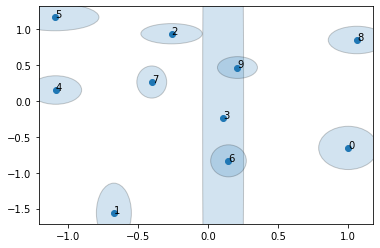

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(mu[:, 0], mu[:, 1])


for i in range(10):
    # oval
    c = pth.Ellipse(xy=(mu[i, 0], mu[i, 1]), width=sigma[i, 0], height=sigma[i, 1], fc=None, ec='black', alpha=0.2)
    ax.add_patch(c)
    # label
    plt.annotate(str(i), xy=(mu[i, 0], mu[i, 1]))

In [37]:
model.eval()
with torch.no_grad():
    img, label = train_dataset[1]
    img = img.to(device).view(1, 1, 28, 28)

    data_mu, data_log_sigma = model(img)
    sim = norm_dist_layer(data_mu, data_log_sigma)

    data_mu, data_sigma = data_mu[0].detach().cpu().numpy(), torch.exp(data_log_sigma[0].detach().cpu()).numpy() ** 2
    print('number: %d' % label)
    print(data_mu)
    print(data_sigma)
    print('sim: ', sim)

number: 0
[ 0.9336139  -0.39010364]
[5.941770e-06 4.438935e-06]
sim:  tensor([[  1.2645, -20.0820, -12.6627,  -5.7769, -13.9193, -12.3268,  -3.1013,
         -18.3584,  -3.4537,  -4.7490]], device='cuda:0')


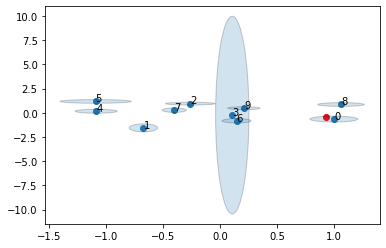

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(mu[:, 0], mu[:, 1])

for i in range(10):
    # oval
    c = pth.Ellipse(xy=(mu[i, 0], mu[i, 1]), width=sigma[i, 0], height=sigma[i, 1], fc=None, ec='black', alpha=0.2)
    ax.add_patch(c)
    # label
    plt.annotate(str(i), xy=(mu[i, 0], mu[i, 1]))

ax.scatter(x=[data_mu[0]], y=[data_mu[1]], c='red')
c = pth.Ellipse(xy=(data_mu[0], data_mu[1]), width=data_sigma[0], height=data_sigma[1], fc='red', ec='red', alpha=0.2)
ax.add_patch(c)